In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Importing libraries
import pandas as pd
import os
import pickle
import random

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

from src.models import parameter_learning as lfi
from src.models import build_model as build
from src.models import model_schemata as schema
from src.models import inference as inf
from src.visualization import visualize as viz

In [3]:
os.chdir('/Users/magdalena/OneDrive - Queen Mary, University of London/bezzlab/research/projects/phospho_pi/')
# os.chdir('/home/mhuebner/Desktop/bezzlab/research/projects/phospho_pi/')

In [4]:
runs = ['run1']

In [5]:
data = {}
for run in runs:
    with open(f'models/ebdt_data/p_model/testing_marginf_relepev_{run}_20i.pkl', 'rb') as f:
        data[run] = pickle.load(f)

In [6]:
data['run1']['p_occupancy']['sample'].unique()

array(['AZD6738', 'Dasatinib', 'GO6983', 'GSK690693', 'KD025', 'KN62',
       'MK2206', 'PD153035', 'PF4708671', 'PIK294', 'Tofacitinib',
       'Ulixertinib', 'Vemurafenib'], dtype=object)

#### Evaluation of learned parameters

In [7]:
p_fc = pd.read_csv('data/processed/ebdt_data/run1/p_fc.csv')

In [8]:
p_fc['p_base'] = 1 - p_fc['p_dec'] - p_fc['p_inc']
p_fc.loc[p_fc['p_base'] < 0, 'p_base'] = 0

In [9]:
# getting sample names (union of all samples in all datasets)
samples = list(set(p_fc['sample']))
samples.sort()
# sample x% of samples randomly without replacement with seed
random.seed(612)
train = random.sample(samples, int(len(samples)*0.8))
test = [x for x in samples if x not in train]
# filter data
p_fc = p_fc[p_fc['sample'].isin(test)]

In [10]:
analysis_dicts = inf.prep_experiments_for_auc(data, p_fc, result_type='p_occupancy', y_true_type='p_fc', threshold=0)

AUC curves

In [11]:
y_onehot_test_list = []
y_score_list = []
experiment_names = []
for exp in analysis_dicts.keys():
    y_onehot_test_list.append(analysis_dicts[exp]['y_onehot_test'])
    y_score_list.append(analysis_dicts[exp]['y_score'])
    experiment_names.append(exp)

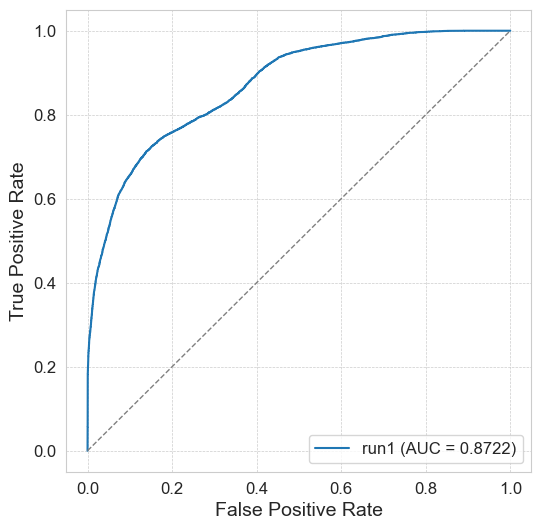

In [13]:
def plot_micro_average_roc_seaborn(y_onehot_tests, y_scores, experiment_names):
    n_experiments = len(experiment_names)

    # Apply Seaborn's default styling
    sns.set_style("whitegrid")

    plt.figure(figsize=(6, 6), dpi=100)

    for i in range(n_experiments):
        fpr, tpr, _ = roc_curve(y_onehot_tests[i].ravel(), y_scores[i].ravel())
        roc_auc = auc(fpr, tpr)

        # Set line style based on experiment number
        linestyle = "--" if i > 9 else "-"  # Dashed line for experiments after exp10

        plt.plot(
            fpr,
            tpr,
            label=f"{experiment_names[i].split('-')[0]} (AUC = {roc_auc:.4f})",
            linestyle=linestyle,
            linewidth=1.5,
        )

    # Add the reference line
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=1)

    # Improve the grid, make it lighter
    plt.grid(True, linestyle='--', linewidth=0.5)

    # Increase the legibility of the ticks
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.xlabel("False Positive Rate", fontsize=14)
    plt.ylabel("True Positive Rate", fontsize=14)
    plt.legend(loc='lower right', fontsize=12)

    plt.show()

# Usage example
plot_micro_average_roc_seaborn(y_onehot_test_list, y_score_list, experiment_names)

In [14]:
analysis_dicts_80 = inf.prep_experiments_for_auc(data, p_fc, result_type='p_occupancy', y_true_type='p_fc', threshold=0.8)
y_onehot_test_list = []
y_score_list = []
experiment_names = []
for exp in analysis_dicts_80.keys():
    y_onehot_test_list.append(analysis_dicts_80[exp]['y_onehot_test'])
    y_score_list.append(analysis_dicts_80[exp]['y_score'])
    experiment_names.append(exp)

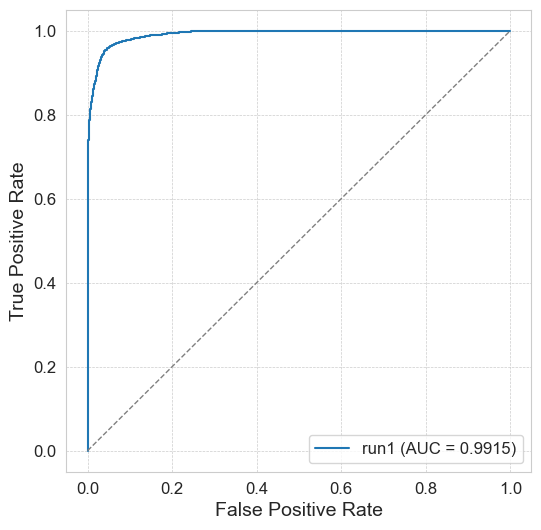

In [15]:
plot_micro_average_roc_seaborn(y_onehot_test_list, y_score_list, experiment_names)

In [16]:
y_onehot_test_list = []
y_score_list = []
experiment_names = []
for exp in analysis_dicts.keys():
    y_onehot_test_list.append(analysis_dicts[exp]['y_onehot_test'])
    y_score_list.append(analysis_dicts[exp]['y_score'])
    experiment_names.append(exp)
for exp in analysis_dicts_80.keys():
    y_onehot_test_list.append(analysis_dicts_80[exp]['y_onehot_test'])
    y_score_list.append(analysis_dicts_80[exp]['y_score'])
    experiment_names.append(f'{exp}_p>0.8')

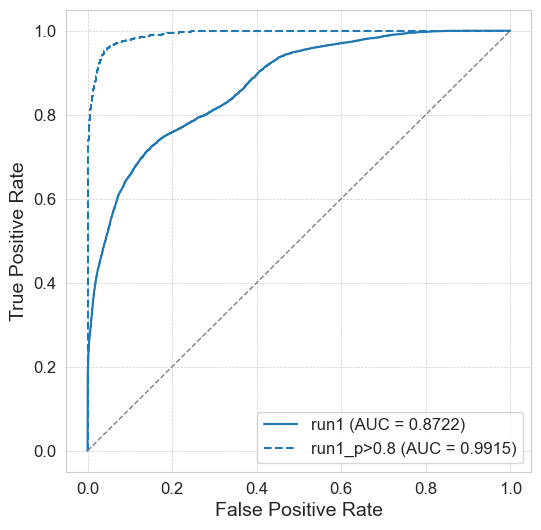

In [17]:
viz.plot_micro_average_roc_seaborn_paired(y_onehot_test_list, y_score_list, experiment_names)

Density plot

In [12]:
# Extracting data from your analysis dictionary
x = analysis_dicts['run1']['analysis_dataframe']['prob']
y = analysis_dicts['run1']['analysis_dataframe']['JSD']
mask_no_match = analysis_dicts['run1']['analysis_dataframe']['MaxMatch'] == 0
mask_mk22 = (analysis_dicts['run1']['analysis_dataframe']['sample'] == 'Dasatinib') & mask_no_match

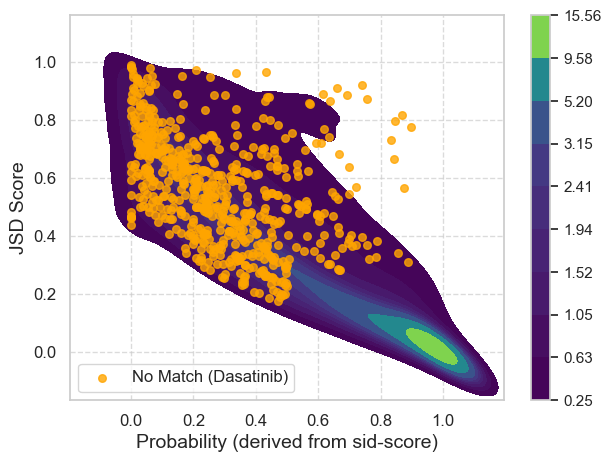

In [13]:
sns.set(style="whitegrid")  # Start with a white grid style

plt.figure(figsize=(7, 5), dpi=100)

# Create the kdeplot
sns.kdeplot(x=x, y=y, cmap='viridis', fill=True, levels=10, cbar=True)

# Scatter plot for 'MaxMatch' == 0 (Non Matches)
plt.scatter(x[mask_mk22], y[mask_mk22], c='orange', s=30, alpha=0.8, label='No Match (Dasatinib)')

# Increase the legibility of the ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adding labels, title, and legend
plt.xlabel('Probability (derived from sid-score)', fontsize=14)
plt.ylabel('JSD Score', fontsize=14)
plt.legend(loc='lower left', fontsize=12)

# Enhance readability
plt.grid(True, linestyle='--', alpha=0.7)
# plt.tight_layout()  # Adjusts the plot to ensure everything fits well

# Display the plot
plt.show()

Tables

In [14]:
mismatch_df = analysis_dicts['run1']['analysis_dataframe'][mask_mk22]

In [15]:
table1 = mismatch_df[mismatch_df['JSD'] > 0.75].sort_values(by=['prob'], ascending=[False]).head(5)
table1 = table1[['phosphosite', 'sample', 'max_category_p_fc', 'prob', 'max_category_p_occupancy', 'JSD']]
table1

,phosphosite,sample,max_category_p_fc,prob,max_category_p_occupancy,JSD
1271,PRKAA2(S173),Dasatinib,p_dec,0.896677,p_inc,0.774555
941,AKAP12(S627),Dasatinib,p_dec,0.867085,p_inc,0.818086
1111,EDC3(S161),Dasatinib,p_inc,0.845969,p_dec,0.795682
579,RASGRP2(S587),Dasatinib,p_dec,0.754840,p_inc,0.871461
266,HMGA1(S44),Dasatinib,p_inc,0.741450,p_dec,0.921462


In [16]:
table2 = mismatch_df[mismatch_df['JSD'] > 0.9].sort_values(by=['prob'], ascending=[False]).tail(10)
table2 = table2[['phosphosite', 'sample', 'max_category_p_fc', 'prob', 'max_category_p_occupancy', 'JSD']]
table2

,phosphosite,sample,max_category_p_fc,prob,max_category_p_occupancy,JSD
171,PDE3B(S318),Dasatinib,p_base,0.018903,p_inc,0.941559
160,MAPT(T548),Dasatinib,p_base,0.018518,p_inc,0.944101
363,CUX1(S1270),Dasatinib,p_base,0.009936,p_inc,0.904916
107,RAF1(S259),Dasatinib,p_base,0.006728,p_dec,0.960292
146,IRS2(S577),Dasatinib,p_base,0.005155,p_dec,0.947380
325,MAPK3(T207),Dasatinib,p_base,0.005098,p_inc,0.910719
41,DSP(S2849),Dasatinib,p_base,0.003271,p_inc,0.975893
20,LMNA(S22),Dasatinib,p_base,0.001257,p_inc,0.983838
26,ATF2(T69),Dasatinib,p_base,0.001000,p_inc,0.982593
3,SYN1(S551),Dasatinib,p_base,0.001000,p_inc,0.991326


In [17]:
analysis_dicts['run1']['analysis_dataframe'][(analysis_dicts['run1']['analysis_dataframe']['phosphosite'] == 'HJURP(S486)') &
                                             (analysis_dicts['run1']['analysis_dataframe']['sample'] == 'MK2206')]

,phosphosite,sample,value,prob,p_dec_p_fc,p_inc_p_fc,p_base_p_fc,p_dec_p_occupancy,p_inc_p_occupancy,p_base_p_occupancy,JSD,max_category_p_fc,max_category_p_occupancy,MaxMatch
12998,HJURP(S486),MK2206,inc,0.965902,0.001,0.965902,0.033098,0.0028,0.994506,0.002694,0.011472,p_inc,p_inc,1
